In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.transform import AffineTransform, warp
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, \
    BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import rotate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, LeakyReLU
from keras.initializers import RandomNormal
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [2]:
sns.set(style='darkgrid', palette='deep')

In [3]:
# List physical GPUs and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)

In [5]:
df.rename(columns={0: 'labels'}, inplace=True)

In [6]:
df = df[df['labels'] != -1]


In [7]:
# Convert the DataFrame to a NumPy array
data = df.to_numpy()

# Extract the labels and images from the NumPy array
labels = data[:, 0]  # Assuming the first column is the labels
images = data[:, 1:]  # The rest are the images

# Optionally, you can reshape and normalize the images if needed
# For example, if the images are 28x28 pixels
images = images.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)
# images = images / 255.0  # Normalize to [0, 1]

# Define the mapping dictionary
mapping = {1: 97, 2: 98, 3: 99, 4: 100, 5: 101, 6: 102, 7: 103, 8: 104, 9: 105, 
           10: 106, 11: 107, 12: 108, 13: 109, 14: 110, 15: 111, 16: 112, 17: 113, 
           18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 120, 25: 121, 
           26: 122, 27: 123}

# Re-map the labels using the mapping dictionary
mapped_labels = np.vectorize(mapping.get)(labels)

# Convert the mapped labels to characters
# labels = np.vectorize(chr)(mapped_labels)

# Now 'images' and 'labels' are NumPy arrays ready for use
print(images.shape)
print(labels.shape)


(88800, 28, 28, 1)
(88800,)


In [8]:
labels

array([23,  7, 16, ..., 18, 24, 19], dtype=int64)

In [9]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (56832, 28, 28, 1)
Validation set shape: (14208, 28, 28, 1)
Test set shape: (17760, 28, 28, 1)


In [10]:
unique_labels = np.unique(y_train)
def Show_Images(data,unique_labels,labels):
    # Create the plot with sufficient subplots
    fig, axes = plt.subplots(3, 9, figsize=(20, 8))  # Adjusted to 3 rows and 9 columns for demonstration
    axes = axes.flatten()

    for label, ax in zip(unique_labels, axes):
        # Select the first image for each unique label
        idx = np.where(labels == label)[0][0]
        image = data[idx].reshape(28, 28)
        
        # Display the image
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    # Hide any remaining empty subplots (if any)
    for ax in axes[len(unique_labels):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show_Images(X_train,unique_labels,y_train)

In [11]:
def plot_images_per_label_Aug_sheer(images, labels, num_images_per_label=5):
    unique_labels = np.unique(labels)
    
    # Create the plot with sufficient subplots
    fig, axes = plt.subplots(len(unique_labels), num_images_per_label * 2, figsize=(20, len(unique_labels) * 2))
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

    # Counter for current axis
    ax_index = 0

    for label in unique_labels:
        # Filter images for the current label
        indices = np.where(labels == label)[0]
        
        # Loop through up to num_images_per_label images for the current label
        for i in range(min(num_images_per_label, len(indices))):
            image = images[indices[i]].reshape(28, 28)
            
            # Display the original image
            axes[ax_index].imshow(image, cmap='gray')
            axes[ax_index].set_title(f'Label: {label}')
            axes[ax_index].axis('off')
            ax_index += 1

            if ax_index >= len(axes):
                break

        for i in range(min(num_images_per_label, len(indices))):
            image = images[indices[i]].reshape(28, 28)

            # Rotate the image by 15 degrees
            rotated_image = rotate(image, -90, reshape=False)
            
            # Apply shear transformation
            # shear_transform = AffineTransform(shear=0.2)
            # sheared_image = warp(rotated_image, shear_transform.inverse, mode='wrap')
            flipped_image = np.fliplr(rotated_image)

            # Display the augmented image
            axes[ax_index].imshow(flipped_image, cmap='gray')
            axes[ax_index].set_title(f'Labels Augmented: {label}')
            axes[ax_index].axis('off')
            ax_index += 1

            if ax_index >= len(axes):
                break

    # Hide any remaining empty subplots (if any)
    for ax in axes[ax_index:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
# plot_images_per_label_Aug_sheer(X_train, y_train)

In [13]:
augmented_images = []
for image in images:
    rotated_image = rotate(image, 90, reshape=False)
    flipped_image = np.flipud(rotated_image)  # Flip vertically
    augmented_images.append(flipped_image)

In [14]:
augmented_images = np.array(augmented_images)

In [15]:
# Split the data into train and test sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(augmented_images, labels, test_size=0.05, random_state=42)
print(f"Training Augmented set shape: {X_train_aug.shape}")
print(f"Test Augmented set shape: {X_test.shape}")

Training Augmented set shape: (84360, 28, 28, 1)
Test Augmented set shape: (17760, 28, 28, 1)


In [16]:
print(f'Augmented Shape : {augmented_images.shape}')
print(f'Label Shape : {labels.shape}')

Augmented Shape : (88800, 28, 28, 1)
Label Shape : (88800,)


In [19]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0001, 0.7)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)
    
    def train(self, epochs, batch_size=256, save_interval=50):
        # Load the dataset
        X_train = X_train_aug
        # Rescale -1 to 1
        X_train = X_train / 255
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (real classified as ones
            # and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # ---------------------
            # Train Generator
            # ---------------------
            # Train the generator (wants discriminator to mistake
            # images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(528, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(1024, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def build_generator(self):
        model = Sequential()
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist_CA2/dcgan_mnist_improved_{:d}.png".format(epoch))
        plt.close()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\p2348935\\Desktop\\Rejey\\DELE\\DELE_CA2\\generated_mnist_CA2\\dcgan_mnist_improved_0.png'

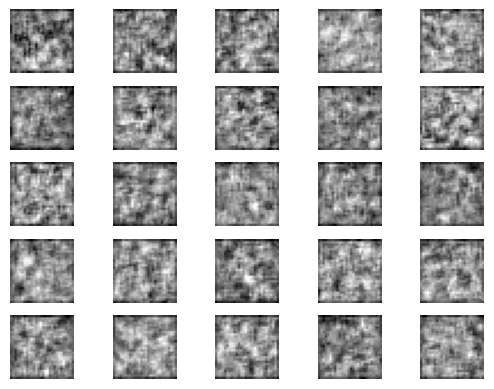

In [20]:
# Set image dimensions
img_rows, img_cols, channels = 28, 28, 1

# Instantiate and train the DCGAN
dcgan = DCGAN(img_rows, img_cols, channels)
dcgan.train(epochs=10000, batch_size=256, save_interval=50)

In [1]:
class DCGAN():
    def __init__(self, rows, cols, channels, z=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def train(self, epochs, batch_size=256, save_interval=50):
        X_train = X_train_aug
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.save_model()

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(256 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 256)))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_improved_%d.png" % epoch)
        plt.close()

    def save_model(self):
        os.makedirs('saved_model', exist_ok=True)
        self.generator.save('saved_model/generator.h5')
        self.discriminator.save('saved_model/discriminator.h5')


In [22]:
# Set image dimensions
img_rows, img_cols, channels = 28, 28, 1

# Instantiate and train the DCGAN
dcgan = DCGAN(img_rows, img_cols, channels)
dcgan.train(epochs=10000, batch_size=256, save_interval=50)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 batch_normalization_16 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                      

KeyboardInterrupt: 